In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from sklearn.metrics import mean_squared_error
import pandas as pd
import syllables
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pragya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/pragya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
input_file = pd.read_csv("output.csv", )
input_file.columns = ['sentence_id', 'word_id', 'word', 'start_time', 'end_time', 'accuracy']
input_file['length'] = input_file.apply (lambda row: len(row["word"]), axis=1)
input_file['syllable_count'] = input_file.apply (lambda row: syllables.estimate(row["word"]), axis=1)
input_file['tmp_offset'] = -1 * (input_file.start_time - input_file.start_time.shift(-1))
input_file.head(10)

,sentence_id,word_id,word,start_time,end_time,accuracy,length,syllable_count,tmp_offset
0,0,0,Mr,0.50,0.78,0.87,2,1,0.28
1,0,1,quilter,0.78,1.20,0.87,7,2,0.42
2,0,2,is,1.20,1.39,0.87,2,1,0.19
3,0,3,the,1.39,1.51,0.87,3,1,0.12
4,0,4,apostle,1.51,2.08,0.87,7,3,0.57
5,0,5,of,2.08,2.24,0.87,2,1,0.16
6,0,6,the,2.24,2.34,0.87,3,1,0.10
7,0,7,middle,2.34,2.58,0.87,6,2,0.24
8,0,8,classes,2.58,3.26,0.87,7,2,0.71
9,0,9,and,3.29,3.44,0.87,3,1,0.15


In [69]:
# input_file.count()

In [70]:
input_file['offset'] = input_file.apply(lambda row: row['tmp_offset'] if row['tmp_offset'] >= 0 else row['end_time'] - row['start_time'], axis=1)
input_file['sentence_length'] = input_file.sentence_id.map(input_file.groupby('sentence_id').count().word_id)
# xtrain = np.array(data.length.values.astype(np.float32)).reshape(-1,1)
# ycorrect = np.array(data.offset.values.astype(np.float32)).reshape(-1,1)
input_file.head()


,sentence_id,word_id,word,start_time,end_time,accuracy,length,syllable_count,tmp_offset,offset,sentence_length
0,0,0,Mr,0.50,0.78,0.87,2,1,0.28,0.28,16
1,0,1,quilter,0.78,1.20,0.87,7,2,0.42,0.42,16
2,0,2,is,1.20,1.39,0.87,2,1,0.19,0.19,16
3,0,3,the,1.39,1.51,0.87,3,1,0.12,0.12,16
4,0,4,apostle,1.51,2.08,0.87,7,3,0.57,0.57,16


In [71]:
input_file[input_file.accuracy > .8].count()

sentence_id        45779
word_id            45779
word               45779
start_time         45779
end_time           45779
accuracy           45779
length             45779
syllable_count     45779
tmp_offset         45778
offset             45779
sentence_length    45779
dtype: int64

In [72]:
input_file['prev_word_1_length'] = input_file.length.shift()
input_file['prev_word_2_length'] = input_file.length.shift(2)
input_file['prev_word_3_length'] = input_file.length.shift(3)
input_file['prev_word_4_length'] = input_file.length.shift(4)
input_file['next_word_1_length'] = input_file.length.shift(-1)
input_file['next_word_2_length'] = input_file.length.shift(-2)
input_file['next_word_3_length'] = input_file.length.shift(-3)
input_file['next_word_4_length'] = input_file.length.shift(-4)
input_file.head()

,sentence_id,word_id,word,start_time,end_time,accuracy,length,syllable_count,tmp_offset,offset,sentence_length,prev_word_1_length,prev_word_2_length,prev_word_3_length,prev_word_4_length,next_word_1_length,next_word_2_length,next_word_3_length,next_word_4_length
0,0,0,Mr,0.50,0.78,0.87,2,1,0.28,0.28,16,NaN,NaN,NaN,NaN,7.0,2.0,3.0,7.0
1,0,1,quilter,0.78,1.20,0.87,7,2,0.42,0.42,16,2.0,NaN,NaN,NaN,2.0,3.0,7.0,2.0
2,0,2,is,1.20,1.39,0.87,2,1,0.19,0.19,16,7.0,2.0,NaN,NaN,3.0,7.0,2.0,3.0
3,0,3,the,1.39,1.51,0.87,3,1,0.12,0.12,16,2.0,7.0,2.0,NaN,7.0,2.0,3.0,6.0
4,0,4,apostle,1.51,2.08,0.87,7,3,0.57,0.57,16,3.0,2.0,7.0,2.0,2.0,3.0,6.0,7.0


In [73]:
input_file.prev_word_1_length = input_file.apply(lambda row: 0 if not row['word_id'] else row['prev_word_1_length'], axis = 1)
input_file.prev_word_2_length = input_file.apply(lambda row: 0 if row['word_id'] in [0,1] else row['prev_word_2_length'], axis = 1)
input_file.prev_word_3_length = input_file.apply(lambda row: 0 if row['word_id'] in [0,1,2] else row['prev_word_3_length'], axis = 1)
input_file.prev_word_4_length = input_file.apply(lambda row: 0 if row['word_id'] in [0,1,2,3] else row['prev_word_4_length'], axis = 1)


input_file.next_word_1_length = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1] else row['next_word_1_length'], axis = 1)
input_file.next_word_2_length = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1,2] else row['next_word_2_length'], axis = 1)
input_file.next_word_3_length = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1,2,3] else row['next_word_3_length'], axis = 1)
input_file.next_word_4_length = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1,2,3,4] else row['next_word_4_length'], axis = 1)


In [74]:
input_file['prev_word_1_syllable_count'] = input_file.syllable_count.shift()
input_file['prev_word_2_syllable_count'] = input_file.syllable_count.shift(2)
input_file['prev_word_3_syllable_count'] = input_file.syllable_count.shift(3)
input_file['prev_word_4_syllable_count'] = input_file.syllable_count.shift(4)
input_file['next_word_1_syllable_count'] = input_file.syllable_count.shift(-1)
input_file['next_word_2_syllable_count'] = input_file.syllable_count.shift(-2)
input_file['next_word_3_syllable_count'] = input_file.syllable_count.shift(-3)
input_file['next_word_4_syllable_count'] = input_file.syllable_count.shift(-4)
input_file.head()

,sentence_id,word_id,word,start_time,end_time,accuracy,length,syllable_count,tmp_offset,offset,...,next_word_3_length,next_word_4_length,prev_word_1_syllable_count,prev_word_2_syllable_count,prev_word_3_syllable_count,prev_word_4_syllable_count,next_word_1_syllable_count,next_word_2_syllable_count,next_word_3_syllable_count,next_word_4_syllable_count
0,0,0,Mr,0.50,0.78,0.87,2,1,0.28,0.28,...,3.0,7.0,NaN,NaN,NaN,NaN,2.0,1.0,1.0,3.0
1,0,1,quilter,0.78,1.20,0.87,7,2,0.42,0.42,...,7.0,2.0,1.0,NaN,NaN,NaN,1.0,1.0,3.0,1.0
2,0,2,is,1.20,1.39,0.87,2,1,0.19,0.19,...,2.0,3.0,2.0,1.0,NaN,NaN,1.0,3.0,1.0,1.0
3,0,3,the,1.39,1.51,0.87,3,1,0.12,0.12,...,3.0,6.0,1.0,2.0,1.0,NaN,3.0,1.0,1.0,2.0
4,0,4,apostle,1.51,2.08,0.87,7,3,0.57,0.57,...,6.0,7.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0


In [75]:
input_file.prev_word_1_syllable_count = input_file.apply(lambda row: 0 if not row['word_id'] else row['prev_word_1_syllable_count'], axis = 1)
input_file.prev_word_2_syllable_count = input_file.apply(lambda row: 0 if row['word_id'] in [0,1] else row['prev_word_2_syllable_count'], axis = 1)
input_file.prev_word_3_syllable_count = input_file.apply(lambda row: 0 if row['word_id'] in [0,1,2] else row['prev_word_3_syllable_count'], axis = 1)
input_file.prev_word_4_syllable_count = input_file.apply(lambda row: 0 if row['word_id'] in [0,1,2,3] else row['prev_word_4_syllable_count'], axis = 1)


input_file.next_word_1_syllable_count = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1] else row['next_word_1_syllable_count'], axis = 1)
input_file.next_word_2_syllable_count = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1,2] else row['next_word_2_syllable_count'], axis = 1)
input_file.next_word_3_syllable_count = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1,2,3] else row['next_word_3_syllable_count'], axis = 1)
input_file.next_word_4_syllable_count = input_file.apply(lambda row: 0 if (row['sentence_length'] - row['word_id'] - 1) in [1,2,3,4] else row['next_word_4_syllable_count'], axis = 1)


In [76]:
input_file['part_of_speech'] = input_file.apply (lambda row: nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] , axis=1)
input_file['is_noun'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] in ['NN','NNS','NNP','NNPS'] else 0, axis=1)
input_file['is_adjective'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] in ['JJ','JJR','JJS'] else 0, axis=1)
input_file['is_pronoun'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] in ['PRP','PRP$','WP','WP$'] else 0, axis=1)
input_file['is_adverb'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] in ['RB','RBR','RBS','WRB'] else 0, axis=1)
input_file['is_verb'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] in ['VB','VBD','VBG','VBN','VBP','VBZ'] else 0, axis=1)
input_file['is_determiner'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] in ['DT','WDT'] else 0, axis=1)
input_file['is_foreign_word'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] == 'FW' else 0, axis=1)
input_file['is_conjunction'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] in ['CC'] else 0, axis=1)
input_file['is_preposition'] = input_file.apply (lambda row: 1 if nltk.pos_tag(nltk.word_tokenize(row["word"]))[0][1] == 'IN' else 0, axis=1)

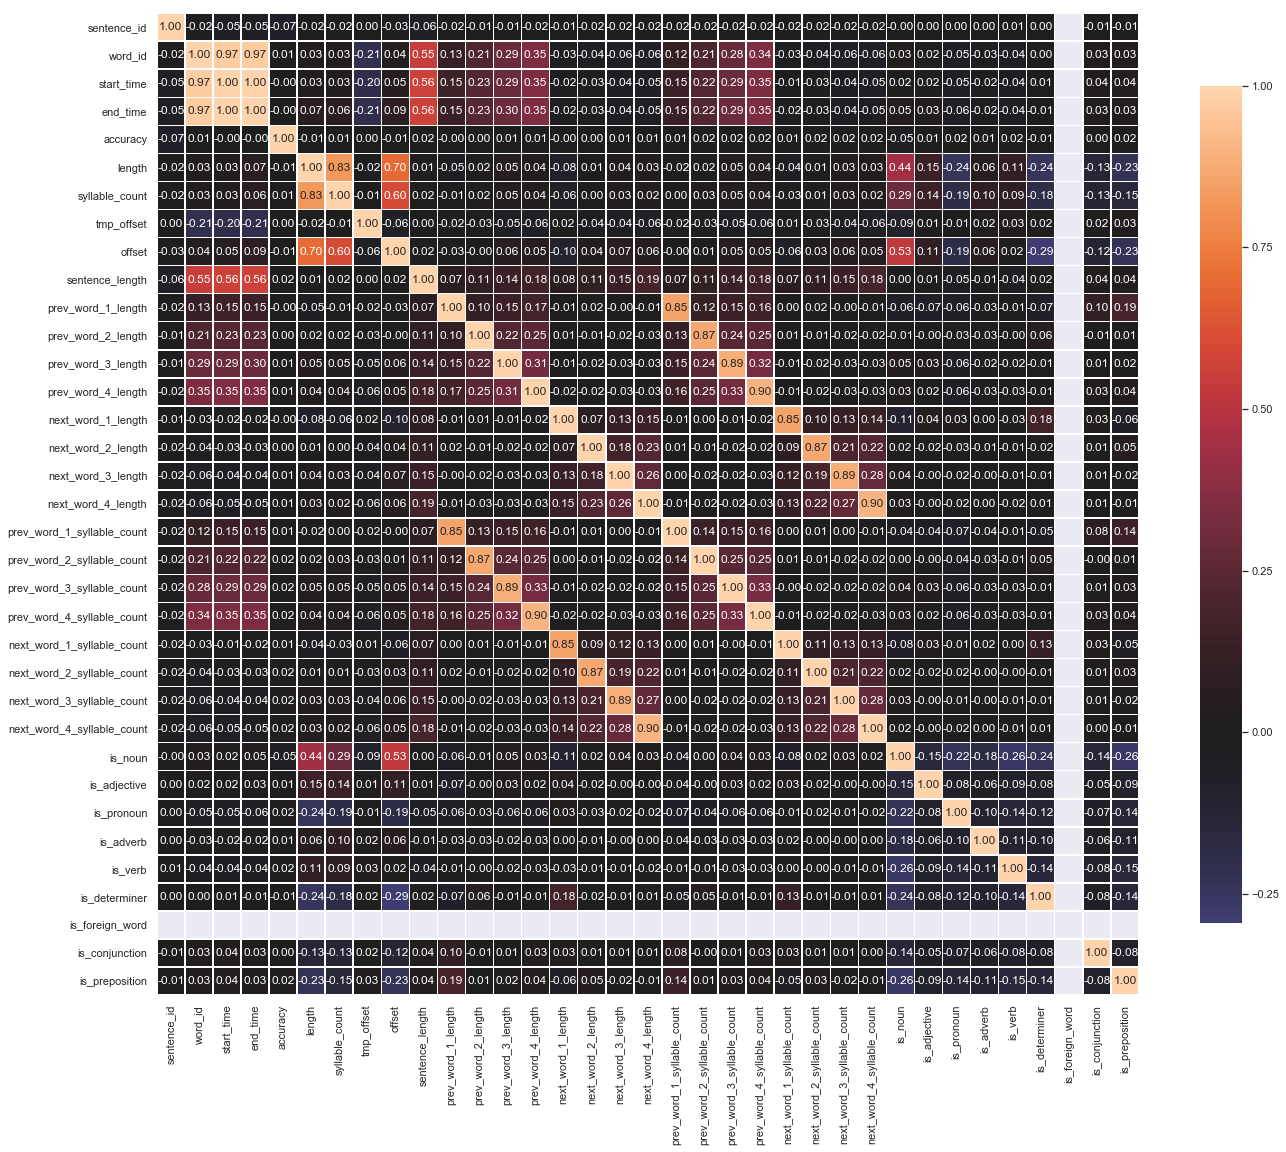

In [14]:
import seaborn as sns; sns.set(rc={'figure.figsize':(22, 22)})
correlations = input_file.corr()

#fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(correlations,
           vmax=1.0,
           center=0,
           fmt='.2f',
           square=True,
           linewidths=.5,
           annot=True,
           cbar_kws={"shrink": .70}
          )

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Frequency')

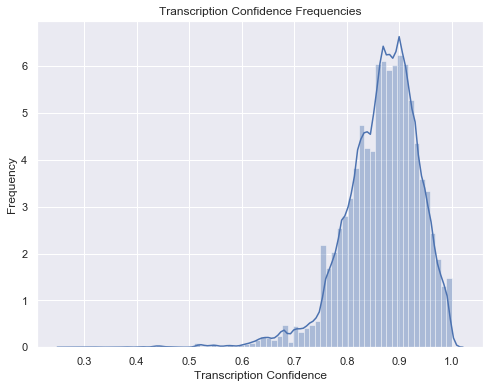

In [63]:
import matplotlib.pyplot as plt


sns.set(rc={'figure.figsize':(8, 6)})
input_file = input_file.fillna(0)
sns.distplot(input_file.accuracy, kde=True, bins=70)
plt.title("Transcription Confidence Frequencies")
plt.xlabel("Transcription Confidence")
plt.ylabel("Frequency")


In [77]:
training_columns = ['length', 'syllable_count',
       'prev_word_1_length', 'prev_word_2_length', 'prev_word_3_length',
       'prev_word_4_length', 'next_word_1_length', 'next_word_2_length',
       'next_word_3_length', 'next_word_4_length', 'is_noun',
       'is_adjective', 'is_pronoun', 'is_adverb', 'is_verb', 'is_determiner',
       'is_conjunction', 'is_preposition',
       'prev_word_1_syllable_count', 'prev_word_2_syllable_count',
       'prev_word_3_syllable_count', 'prev_word_4_syllable_count',
       'next_word_1_syllable_count', 'next_word_2_syllable_count',
       'next_word_3_syllable_count', 'next_word_4_syllable_count']
mses=[]
confs = []
lens = []


for i in range(0, 101, 10):
    
    z = i / 100
    temp_input_file = input_file[input_file.accuracy >= z]
    train, test = train_test_split(temp_input_file, test_size=0.2, shuffle=False, random_state = 1)
    lens.append(len(temp_input_file))

    test = test[test.accuracy > .9]
    
    train_x = train[training_columns]
    train_y = np.array(train.offset.values.astype(np.float32))

    test_x = test[training_columns]
    test_y = np.array(test.offset.values.astype(np.float32))
    regr = RandomForestRegressor(n_estimators= 42)
    regr.fit(train_x, train_y)
#     print(regr.feature_importances_)
    y_pred_regr = regr.predict(test_x)
    mse = mean_squared_error(y_pred_regr, test_y)
    mses.append(mse)
    confs.append(z)
    print("for i = ", i, " mse = ", mse)

# sns.scatterplot(confs, mses)

for i =  0  mse =  0.018563123790628223
for i =  10  mse =  0.01812689117807194
for i =  20  mse =  0.01833982285270408
for i =  30  mse =  0.018592968891004574
for i =  40  mse =  0.018328283985919513
for i =  50  mse =  0.018432763859116123
for i =  60  mse =  0.01860629531843725
for i =  70  mse =  0.018368068122712647
for i =  80  mse =  0.01867224287025549
for i =  90  mse =  0.019122682177616396
for i =  100  mse =  0.02464101800573609


In [67]:
input_file

,sentence_id,word_id,word,start_time,end_time,accuracy,length,syllable_count,tmp_offset
0,0,0,Mr,0.50,0.78,0.87,2,1,0.28
1,0,1,quilter,0.78,1.20,0.87,7,2,0.42
2,0,2,is,1.20,1.39,0.87,2,1,0.19
3,0,3,the,1.39,1.51,0.87,3,1,0.12
4,0,4,apostle,1.51,2.08,0.87,7,3,0.57
5,0,5,of,2.08,2.24,0.87,2,1,0.16
6,0,6,the,2.24,2.34,0.87,3,1,0.10
7,0,7,middle,2.34,2.58,0.87,6,2,0.24
8,0,8,classes,2.58,3.26,0.87,7,2,0.71
9,0,9,and,3.29,3.44,0.87,3,1,0.15


Text(0, 0.5, 'MSE')

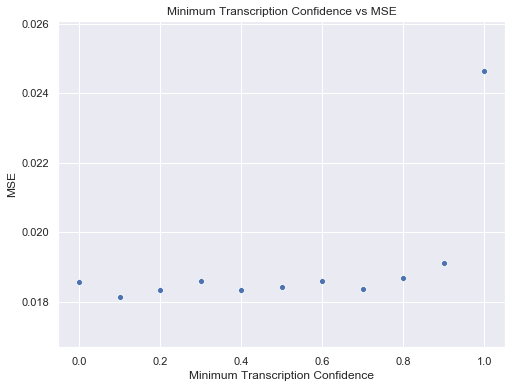

In [84]:
import matplotlib.pyplot as plt

sns.scatterplot(confs, mses)

plt.title("Minimum Transcription Confidence vs MSE")
plt.xlabel("Minimum Transcription Confidence")
plt.ylabel("MSE")

Text(0, 0.5, 'Number of Records')

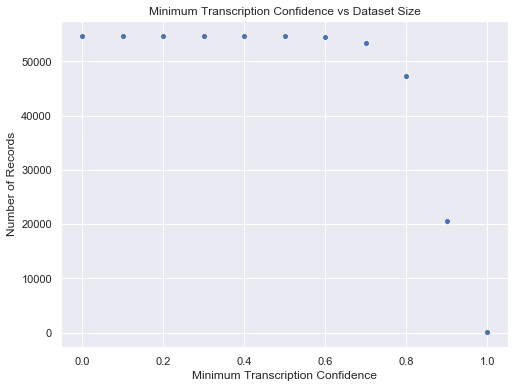

In [85]:
sns.scatterplot(confs, lens)
plt.title("Minimum Transcription Confidence vs Dataset Size")
plt.xlabel("Minimum Transcription Confidence")
plt.ylabel("Number of Records")

In [173]:
train_x.transpose().iloc[:, 0:10]

,0,1,2,3,4,5,6,7,8,9
length,2.0,7.0,2.0,3.0,7.0,2.0,3.0,6.0,7.0,3.0
syllable_count,1.0,2.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0
prev_word_1_length,0.0,2.0,7.0,2.0,3.0,7.0,2.0,3.0,6.0,7.0
prev_word_2_length,0.0,0.0,7.0,2.0,3.0,7.0,2.0,3.0,6.0,7.0
prev_word_3_length,0.0,0.0,0.0,2.0,3.0,7.0,2.0,3.0,6.0,7.0
prev_word_4_length,0.0,0.0,0.0,0.0,3.0,7.0,2.0,3.0,6.0,7.0
next_word_1_length,7.0,2.0,3.0,7.0,2.0,3.0,6.0,7.0,3.0,5.0
next_word_2_length,2.0,3.0,7.0,2.0,3.0,6.0,7.0,3.0,5.0,4.0
next_word_3_length,3.0,7.0,2.0,3.0,6.0,7.0,3.0,5.0,4.0,2.0
next_word_4_length,7.0,2.0,3.0,6.0,7.0,3.0,5.0,4.0,2.0,7.0


In [43]:
from sklearn.ensemble import RandomForestRegressor
input_file = input_file[input_file.accuracy >= .7]
train, test = train_test_split(temp_input_file, test_size=0.2, shuffle=False, random_state = 1)

train_x = train[training_columns]
train_y = np.array(train.offset.values.astype(np.float32))

test_x = test[training_columns]
test_y = np.array(test.offset.values.astype(np.float32))
    
regr = RandomForestRegressor(n_estimators= 10)
regr.fit(train_x, train_y)
print(regr.feature_importances_)

y_pred_regr = regr.predict(test_x)


mean_squared_error(y_pred_regr, test_y)

[5.16588335e-01 2.09046846e-01 3.03879259e-02 4.32981299e-03
 3.10090299e-02 1.80696788e-02 3.37295633e-02 4.46342906e-03
 1.87883705e-02 1.86877862e-02 6.08659055e-02 2.94443326e-03
 1.74033816e-03 0.00000000e+00 8.77448282e-03 3.85811688e-03
 0.00000000e+00 2.96472235e-03 5.44783352e-05 2.44585726e-03
 5.35265525e-03 1.28001743e-04 5.10799130e-04 6.47532526e-04
 2.22132074e-02 2.39869201e-03]


0.027634998748910972

In [44]:
from sklearn.model_selection import cross_val_score
import seaborn as sns; sns.set()

list = []
for i in range(1, 101, 10):
    regr = RandomForestRegressor(n_estimators=i)
    scores = cross_val_score(regr, train_x, train_y, cv=5, scoring="neg_mean_squared_error")
    print(scores)
    list.append(scores.mean())
x = np.array([i for i in range(1, 101, 10)])

list


[-0.00788889 -0.01176667 -0.05376667 -0.01268889 -0.045525  ]
[-0.01319054 -0.01653443 -0.02280624 -0.01172387 -0.03089504]
[-0.01087012 -0.01097692 -0.01596311 -0.00896344 -0.02351117]
[-0.0105405  -0.01360292 -0.01765387 -0.01047253 -0.02896455]
[-0.01092509 -0.01111768 -0.02392253 -0.00885056 -0.02537182]
[-0.0103436  -0.01220876 -0.02195374 -0.01251105 -0.03027467]
[-0.01128843 -0.01093048 -0.0234689  -0.00762297 -0.02050276]
[-0.01323495 -0.01042782 -0.02039973 -0.00709711 -0.03178264]
[-0.01336678 -0.00944849 -0.02084079 -0.00901145 -0.02760813]
[-0.01272054 -0.01128877 -0.02182957 -0.00733195 -0.02822411]


[-0.026327221013224916,
 -0.01903002656375135,
 -0.014056952032443898,
 -0.016246874784029686,
 -0.016037538203644248,
 -0.01745836582456429,
 -0.01476270762997399,
 -0.016588448982065546,
 -0.016055126977292302,
 -0.01627898708230946]

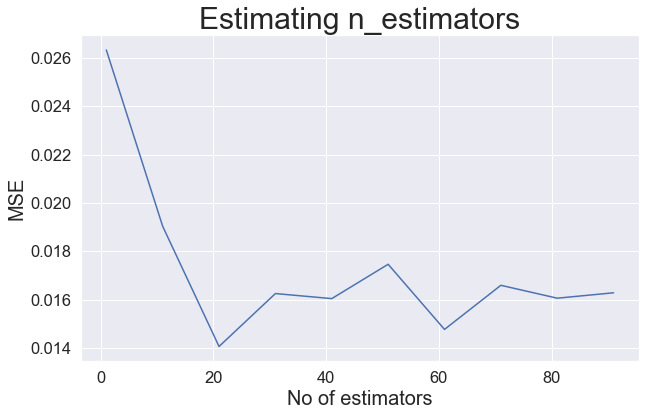

In [45]:
sns.set(font_scale=1.5, rc={'figure.figsize':(10, 6)})
sns_plot = sns.lineplot(x=x, y=[abs(i) for i in list])
sns_plot.axes.set_title("Estimating n_estimators",fontsize=30)
sns_plot.set_xlabel("No of estimators",fontsize=20)
sns_plot.set_ylabel("MSE",fontsize=20)
sns_plot.figure.savefig("output.png")

[3.44121342e-01 3.42563400e-01 2.84765992e-02 1.41891574e-02
 2.69563201e-02 1.49109123e-02 7.58539943e-03 1.07799232e-02
 2.06241119e-02 3.90365076e-03 1.11363445e-01 1.85019536e-03
 2.76474796e-03 0.00000000e+00 1.60584198e-02 7.77081580e-04
 0.00000000e+00 1.56464011e-04 1.29542866e-02 2.86146169e-04
 1.68089407e-02 4.34433202e-03 2.85390591e-03 8.50141906e-03
 3.95284616e-03 3.21695296e-03]


,Feature,Importance
0,length,0.344121
1,syllable_count,0.342563
10,is_noun,0.111363
2,prev_word_1_length,0.028477
4,prev_word_3_length,0.026956
8,next_word_3_length,0.020624
20,prev_word_3_syllable_count,0.016809
14,is_verb,0.016058
5,prev_word_4_length,0.014911
3,prev_word_2_length,0.014189


Text(0.5, 1.0, 'Feature Importances')

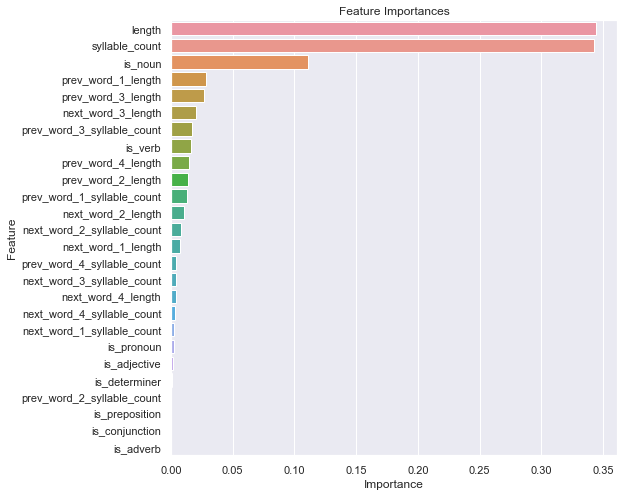

In [62]:
regr1 = RandomForestRegressor(n_estimators=22)
regr1.fit(train_x, train_y)
print(regr1.feature_importances_)

y_pred_regr1 = regr1.predict(test_x)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_regr1, test_y)
# print(regr1.feature_importances_)
importance = regr1.feature_importances_
sns.set
ftr_imp = pd.DataFrame.from_dict({'Feature': training_columns, 'Importance': importance})
ftr_imp = ftr_imp.sort_values(by='Importance', ascending=False)
display(ftr_imp)
sns.set(rc={'figure.figsize':(8, 8)})
sns.barplot(y= "Feature", x="Importance", data = ftr_imp)
plt.title("Feature Importances")

In [163]:
prediction = pd.DataFrame.from_dict({'word': test.word,'word_id': test.word_id, 'sentence_id': test.sentence_id, 'sentence_length': test.sentence_length.astype(int) , 'label': test_y, 'prediction': y_pred_regr})
prediction.head(30)
prediction.sentence_length.max()
prediction.to_csv("final_predictions.csv")

In [147]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()
ada.fit(train_x, train_y)
importance = ada.feature_importances_
# for i in range(len(training_columns)):
#     print (training_columns , importance)
ftr_imp = pd.DataFrame.from_dict({'feature': training_columns, 'importance': importance})
y_pred_ada = ada.predict(test_x)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_ada, test_y)

0.057019544711435236

In [132]:
ftr_imp = ftr_imp.sort_values(by='importance', ascending=False)
display(ftr_imp)

,feature,importance
0,length,0.490679
1,syllable_count,0.117417
10,is_noun,0.108010
6,next_word_1_length,0.037309
11,is_adjective,0.031273
8,next_word_3_length,0.029453
18,prev_word_1_syllable_count,0.026486
5,prev_word_4_length,0.025839
9,next_word_4_length,0.019439
15,is_determiner,0.018251


In [149]:
prediction = pd.DataFrame.from_dict({'label': test_y, 'prediction': y_pred_ada})
prediction.head(30)

,label,prediction
0,0.25,0.513488
1,0.20,0.381104
2,0.10,0.282059
3,0.15,0.506580
4,0.51,0.711280
5,0.19,0.509432
6,0.31,0.462719
7,0.43,0.633134
8,0.19,0.521235
9,0.15,0.381104
